## Improving User Engagement on Quora Mobile App

Suppose you are a Data Scientist on the Mobile team at Quora. The team has just introduced a new UI design to the Quora app. The goal of the new design is to increase user engagement (measured by minutes spent on site). The team ran an A/B test to evaluate the change. Using the data, help the team understand the impact of the UI change better.

Tables provided are as follows:
    1. t1_user_active_min.csv
    2. t2_user_variant.csv
    3. t3_user_active_min_pre.csv
    4. t4_user_attributes.csv

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from datetime import timedelta
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
pd.set_option('float_format', '{:f}'.format)

from scipy import stats
from scipy.stats import ttest_ind_from_stats
from statsmodels.stats.power import TTestIndPower

In [ ]:
t1_usr_active_min = pd.read_csv("t1_user_active_min.csv")
t2_usr_variant = pd.read_csv("t2_user_variant.csv")
t3_usr_active_min_pre = pd.read_csv("t3_user_active_min_pre.csv")
t4_usr_attributes = pd.read_csv("t4_user_attributes.csv")

In [ ]:
print("t1_user_active_min")
t1_usr_active_min.head(2)
print("t2_user_variant")
t2_usr_variant.head(2)
print("t3_user_active_min_pre")
t3_usr_active_min_pre.head(2)
print("t4_user_attributes")
t4_usr_attributes.head(2)

t1_user_active_min


,uid,dt,active_mins
0,0,2019-02-22,5.000000
1,0,2019-03-11,5.000000


t2_user_variant


,uid,variant_number,dt,signup_date
0,0,0,2019-02-06,2018-09-24
1,1,0,2019-02-06,2016-11-07


t3_user_active_min_pre


,uid,dt,active_mins
0,0,2018-09-24,3.000000
1,0,2018-11-08,4.000000


t4_user_attributes


,uid,gender,user_type
0,0,male,non_reader
1,1,male,reader


In [ ]:
print("Pre Experiments date range:", t3_usr_active_min_pre.dt.min()," - ",t2_usr_variant.dt.max())
print("Duration of Experiment:",t1_usr_active_min.dt.min()," - ", t1_usr_active_min.dt.max())

delta = dt.strptime(t1_usr_active_min.dt.max(),"%Y-%m-%d")-dt.strptime(t1_usr_active_min.dt.min(),"%Y-%m-%d")
print("Experiment Duration(Days):",delta.days+1)

Pre Experiments date range: 2018-08-10  -  2019-02-06
Duration of Experiment: 2019-02-06  -  2019-07-05
Experiment Duration(Days): 150


### Exploring User Distribtion for control & treatment group

In [ ]:
t2_usr_variant['variant_number'].value_counts()
print("Train - Test ratio: 80% - 20%")

0    40000
1    10000
Name: variant_number, dtype: int64

Train - Test ratio: 80% - 20%


In [ ]:
## Checking no. of unique users
t2_usr_variant.uid.nunique()
t1_usr_active_min.uid.nunique()
t3_usr_active_min_pre.uid.nunique()

50000

46633

49697

### Preparing a master table with user

Preparing now a master table with these following important user informations: User Daily Activity (uid, active_min), 
User Signup, User Variant Number, User characteristics (gender, user_types). Motive to prepare this dataset is to have table with complete user details and use this for hypothesis testing and further insights.

<b>I have specifically done  a left join of t2_usr_varient table with t1_usr_active_min so as to preserve the activity (or non-activity) of all the 50000 users who are are part of the control & treatment group.</b>

In [ ]:
usr_postexp_df = pd.merge(t2_usr_variant,t1_usr_active_min, on='uid', how='left')
usr_postexp_df = pd.merge(usr_postexp_df,t4_usr_attributes, on='uid', how='left')
usr_postexp_df.shape
usr_postexp_df.uid.nunique()
usr_postexp_df.head(2)

(1069769, 8)

50000

,uid,variant_number,dt_x,signup_date,dt_y,active_mins,gender,user_type
0,0,0,2019-02-06,2018-09-24,2019-02-22,5.000000,male,non_reader
1,0,0,2019-02-06,2018-09-24,2019-03-11,5.000000,male,non_reader


In [ ]:
usr_postexp_df.rename(columns={'dt_x':'experiement_dt','dt_y':'dt'}, inplace=True )

### We know that the expriment was live for 150 days, so I am checking in the following codes if the user were active daily or not. My motive is to have an apple to apple comparison for same no of days, the mean active mins for control and treatment group

In [ ]:
temp = usr_postexp_df.groupby(['uid','variant_number'], as_index=False).agg({'dt':'count','active_mins': 'sum'})
temp.rename(columns={'active_mins': 'tot_mins','dt': 'tot_days'},inplace=True)
temp.head()
temp.tot_days.unique()
temp.groupby(['variant_number'], as_index=False).agg({'tot_days':'mean','tot_mins':'mean'})

,uid,variant_number,tot_days,tot_mins
0,0,0,13,43.000000
1,1,0,95,15205.000000
2,2,0,7,17.000000
3,3,0,24,77.000000
4,4,0,20,39.000000


array([ 13,  95,   7,  24,  20,  14,   0,   9,  31,   6,   2,  12,  18,
        89,  34,  10,  35,  33,  37,  81,  56,  17,  16,  21,  50,  30,
         5,  25,   1,  15,   8,  62,  11,  54,   3,   4,  55,  59,  27,
        40,  19,  58,  66,  64,  71,  29,  57,  41,  23, 103,  60,  80,
        76,  38,  32,  84,  92,  39,  70,  74,  51,  45,  77,  22,  63,
        75,  28,  72,  43,  53,  67,  26,  93,  88,  42,  36,  68,  91,
        83,  49,  48,  47,  86,  97,  99,  65,  69,  82,  44, 102,  61,
        98, 101,  46, 100,  85,  94,  78,  96,  52,  87,  79,  90,  73,
       106, 104, 107, 105, 108, 110, 109])

,variant_number,tot_days,tot_mins
0,0,22.173925,783.719625
1,1,17.944500,722.094000


### Thus, from the above two aggregates function we see that no user (either 0/1 variant) was present for all single day of the experiment. Also the mean days control & treatment group users were active is 22 and 18 days respectively. Thus we now need to populate the above table for each day of the experiement and compare the means of the two groups

### Also from the last table, we see that there is a difference between the average tot_mins spend by users in control and treatment groups, but we need to be check if there are many outliers (like15202.0) misrepresenting this number.

## Outlier Treatment

From the `usr_postexp_df` df, only column 'active_mins' has outliers in it. Since a day has maximum 1440 mins, therefore I am removing all the entries with values greater than 1500 mins (taken a buffer of 60 mins more)

In [ ]:
usr_postexp_df.describe()
#plt.hist(usr_postexp_df.active_mins)
usr_postexp_df[usr_postexp_df.active_mins>=1500].shape
usr_postexp_df[usr_postexp_df.active_mins==99999].shape

,uid,variant_number,active_mins
count,1069769.000000,1069769.000000,1066402.000000
mean,24226.815362,0.168482,36.168091
std,14175.415856,0.374294,1270.483515
min,0.000000,0.000000,1.000000
25%,12023.000000,0.000000,2.000000
50%,23945.000000,0.000000,5.000000
75%,36186.000000,0.000000,17.000000
max,49999.000000,1.000000,99999.000000


(172, 8)

(172, 8)

In [ ]:
usr_postexp_df.shape
temp = usr_postexp_df['active_mins'] >=1500
usr_postexp_df2 = usr_postexp_df[~temp]
usr_postexp_df.shape[0]-usr_postexp_df2.shape[0]

(1069769, 8)

172

Thus we have removed the outlier values: 172 entries with active_mins >=1500 mins

In [ ]:
usr_postexp_df2.head()
usr_postexp_df2.isna().sum()

,uid,variant_number,experiement_dt,signup_date,dt,active_mins,gender,user_type
0,0,0,2019-02-06,2018-09-24,2019-02-22,5.000000,male,non_reader
1,0,0,2019-02-06,2018-09-24,2019-03-11,5.000000,male,non_reader
2,0,0,2019-02-06,2018-09-24,2019-03-18,3.000000,male,non_reader
3,0,0,2019-02-06,2018-09-24,2019-03-22,4.000000,male,non_reader
4,0,0,2019-02-06,2018-09-24,2019-04-03,9.000000,male,non_reader


uid                  0
variant_number       0
experiement_dt       0
signup_date          0
dt                3367
active_mins       3367
gender               0
user_type            0
dtype: int64

From the above NA value table, we see that there are around 3367 users for whom there is no activity even for a single day.

In [ ]:
temp = usr_postexp_df2[usr_postexp_df2.active_mins.isna()]
temp.shape
temp.head()
temp.uid.nunique()
temp.groupby(['variant_number'],as_index=False).agg({'uid':'nunique'})

(3367, 8)

,uid,variant_number,experiement_dt,signup_date,dt,active_mins,gender,user_type
193,8,0,2019-02-06,2019-01-18,NaN,nan,male,new_user
258,12,0,2019-02-06,2017-04-20,NaN,nan,male,non_reader
797,35,0,2019-02-06,2019-01-25,NaN,nan,male,new_user
1612,78,0,2019-02-06,2014-08-11,NaN,nan,male,non_reader
1905,94,0,2019-02-06,2019-02-03,NaN,nan,female,new_user


3367

,variant_number,uid
0,0,2575
1,1,792


### Thus we see that a lot of users (3k+) from control group and also treatment groups have shown no activity during the experiment period. 
### Currently, I am removing these users since for these users the active_mins will be 0 for all days and since they were not active even for single day, so they didn't see the newly designed UI and hence have no role to play.

In [ ]:
usr_postexp_dfnew = usr_postexp_df2[~usr_postexp_df2.active_mins.isna()]
usr_postexp_dfnew.shape
usr_postexp_dfnew.head()

(1066230, 8)

,uid,variant_number,experiement_dt,signup_date,dt,active_mins,gender,user_type
0,0,0,2019-02-06,2018-09-24,2019-02-22,5.000000,male,non_reader
1,0,0,2019-02-06,2018-09-24,2019-03-11,5.000000,male,non_reader
2,0,0,2019-02-06,2018-09-24,2019-03-18,3.000000,male,non_reader
3,0,0,2019-02-06,2018-09-24,2019-03-22,4.000000,male,non_reader
4,0,0,2019-02-06,2018-09-24,2019-04-03,9.000000,male,non_reader


Let's look at the variant number 0/1 wise the mean active_mins and it's std deviation.

In [ ]:
usr_postexp_dfnew.groupby(['variant_number'],as_index=False).active_mins.agg({'mean','std','median'})

,mean,median,std
variant_number,,,
0,19.337660,5.000000,44.797631
1,23.526294,7.000000,54.191356


#### Populating the above df for each user * 150 days of experiment. This will give us an apple-to-apply comparison, ie the daily acitve _min for each user for every single day when the experiment was live


In [ ]:
daily_usr_act = usr_postexp_dfnew.pivot_table(index=['variant_number','uid','experiement_dt','signup_date',
                                                      'gender','user_type'],columns = 'dt',values='active_mins',fill_value=0).reset_index()
daily_usr_act = daily_usr_act.melt(id_vars=['variant_number','uid','experiement_dt','signup_date',
                                                      'gender','user_type'], var_name='dt',value_name='active_mins')
print("Before a& After reshaping the data at daily level:",usr_postexp_dfnew.shape, daily_usr_act.shape)

Before a& After reshaping the data at daily level: (1066230, 8) (6994950, 8)


### Let's now see the impact of new UI on average active_mins for control and treatment group

In [ ]:
daily_usr_act.groupby(['variant_number'],as_index=False).active_mins.agg({'mean','std','median','var','count'})

,median,var,mean,std,count
variant_number,,,,,
0,0,366.763169,3.054808,19.151062,5613750
1,0,444.027311,3.056017,21.071956,1381200


In [ ]:
mean_0 = daily_usr_act[daily_usr_act['variant_number']==0].active_mins.mean()
mean_1 = daily_usr_act[daily_usr_act['variant_number']==1].active_mins.mean()

std_0 = daily_usr_act[daily_usr_act['variant_number']==0].active_mins.std()
std_1 = daily_usr_act[daily_usr_act['variant_number']==1].active_mins.std()

nobs0 = daily_usr_act[daily_usr_act['variant_number']==0].active_mins.count()
nobs1 = daily_usr_act[daily_usr_act['variant_number']==1].active_mins.count()

### Performing t-test to understand if there was any impact of new UI on user's dUIaily engagement

<b> <u>Null Hypothesis Ho:</u> New UI had no effect on daily user enagegment i.e. there is no difference in control and variant users' average active mins
<u>Alternate Hypothesis:</u> New UI had an effect on daily user engagment, .e. there is a difference in control and variant users' average active mins</b>

Here using the Welch t-test because both variane and sample sizes of two groups are different.

In [ ]:
ttest_ind_from_stats(mean1=mean_1,std1=std_1,nobs1=nobs1,
                     mean2=mean_0,std2=std_0,nobs2=nobs0, equal_var=False)

Ttest_indResult(statistic=0.06145955015857426, pvalue=0.9509932339796476)

<b> The p-value from the above t-test is very high and thus we fail to reject the null-hypothesis. </b>
#### Preparing Confidence Interval

In [ ]:
def calc_CI(mean_1,std_1,nobs1,mean_0,std_0,nobs0,CI_interval):
    se = np.sqrt((std_1 * std_1) / nobs1 + (std_0 * std_0) / nobs0)
    mean_diff = mean_1-mean_0
    qt = stats.norm.isf((1-CI_interval)/2)
    lower = mean_diff - qt*se
    upper = mean_diff + qt*se
    return (lower,upper)


In [ ]:
CI = calc_CI(mean_1,std_1,nobs1,mean_0,std_0,nobs0,0.95)
CI

(-0.03733892403590165, 0.039756441143676366)

## Pre and Post Experiment Data Analysis

You decide to dive deeper into the data, so you gather a table of active minutes by user from before the experiment began. You should now use table 3 (t3_user_active_min_pre.csv) along with tables 1 and 2 for this question.

Using the statistical method of your choice and the pre-experiment data, update your 95% confidence interval of the overall average treatment effect.

Please enter your confidence interval below, after rounding your answer to second place after the decimal.

In [ ]:
print("Pre Experiments date range:", t3_usr_active_min_pre.dt.min()," - ",t2_usr_variant.dt.max())
print("Duration of Experiment:",t1_usr_active_min.dt.min()," - ", t1_usr_active_min.dt.max())

delta = dt.strptime(t1_usr_active_min.dt.max(),"%Y-%m-%d")-dt.strptime(t1_usr_active_min.dt.min(),"%Y-%m-%d")
predelta = dt.strptime(t3_usr_active_min_pre.dt.max(),"%Y-%m-%d")-dt.strptime(t3_usr_active_min_pre.dt.min(),"%Y-%m-%d") 
print("Experiment Duration(Days):",delta.days+1)
print("Pre Experiment Duration(Days):",predelta.days+1)

Pre Experiments date range: 2018-08-10  -  2019-02-06
Duration of Experiment: 2019-02-06  -  2019-07-05
Experiment Duration(Days): 150
Pre Experiment Duration(Days): 180


#### In the following lines of code, I reiterating steps & function used above to prepare data ready for t-test and CI calculation.
#### Steps taken:

- Preparing Master Table: pre-experiement 0/1 variant group's average activity mins
- Outlier removal
- Performing T-test for pre and post experiment data

In [ ]:
usr_preexp_df = pd.merge(t2_usr_variant,t3_usr_active_min_pre,on="uid",how="left")
preexp_usr_df = pd.merge(usr_preexp_df,t4_usr_attributes,on="uid",how="left")
preexp_usr_df.shape
preexp_usr_df.uid.nunique()
preexp_usr_df.head(3)

(1190396, 8)

50000

,uid,variant_number,dt_x,signup_date,dt_y,active_mins,gender,user_type
0,0,0,2019-02-06,2018-09-24,2018-09-24,3.000000,male,non_reader
1,0,0,2019-02-06,2018-09-24,2018-11-08,4.000000,male,non_reader
2,0,0,2019-02-06,2018-09-24,2018-11-24,3.000000,male,non_reader


In [ ]:
preexp_usr_df.rename(columns={'dt_x':'experiement_dt','dt_y':'dt'}, inplace=True )

### Outlier Treatment

In [ ]:
preexp_usr_df.describe()
#plt.hist(usr_postexp_df.active_mins)
preexp_usr_df[preexp_usr_df.active_mins>=1500].shape

,uid,variant_number,active_mins
count,1190396.000000,1190396.000000,1190093.000000
mean,24206.442924,0.168585,32.203151
std,14180.354303,0.374385,1181.530546
min,0.000000,0.000000,1.000000
25%,11975.000000,0.000000,2.000000
50%,23933.000000,0.000000,4.000000
75%,36197.250000,0.000000,14.000000
max,49999.000000,1.000000,99999.000000


(166, 8)

In [ ]:
preexp_usr_df.shape
temp = preexp_usr_df['active_mins'] >=1500
preexp_usr_df2 = preexp_usr_df[~temp]
preexp_usr_df.shape[0]-preexp_usr_df2.shape[0]

(1190396, 8)

166

Thus we have removed the outlier values: 166 entries with active_mins >=1500 mins

In [ ]:
preexp_usr_df2.head()
preexp_usr_df2.isna().sum()

,uid,variant_number,experiement_dt,signup_date,dt,active_mins,gender,user_type
0,0,0,2019-02-06,2018-09-24,2018-09-24,3.000000,male,non_reader
1,0,0,2019-02-06,2018-09-24,2018-11-08,4.000000,male,non_reader
2,0,0,2019-02-06,2018-09-24,2018-11-24,3.000000,male,non_reader
3,0,0,2019-02-06,2018-09-24,2018-11-28,6.000000,male,non_reader
4,0,0,2019-02-06,2018-09-24,2018-12-02,6.000000,male,non_reader


uid                 0
variant_number      0
experiement_dt      0
signup_date         0
dt                303
active_mins       303
gender              0
user_type           0
dtype: int64

### Here we see that around 303 users have no activity during the pre-experiment period. It would be interesting to see if they had any activity during the experiment days and if so, did they have signup enough days before the launch of experiment

In [ ]:
temp = preexp_usr_df2[preexp_usr_df2.dt.isna()]
check_ifactivity = pd.merge(usr_postexp_dfnew,temp, on = "uid",how="inner")
check_ifactivity.shape
check_ifactivity.uid.nunique()
check_ifactivity.head()

(642, 15)

155

,uid,variant_number_x,experiement_dt_x,signup_date_x,dt_x,active_mins_x,gender_x,user_type_x,variant_number_y,experiement_dt_y,signup_date_y,dt_y,active_mins_y,gender_y,user_type_y
0,148,0,2019-02-06,2016-09-16,2019-02-06,7.000000,female,non_reader,0,2019-02-06,2016-09-16,NaN,nan,female,non_reader
1,148,0,2019-02-06,2016-09-16,2019-03-09,1.000000,female,non_reader,0,2019-02-06,2016-09-16,NaN,nan,female,non_reader
2,148,0,2019-02-06,2016-09-16,2019-03-24,2.000000,female,non_reader,0,2019-02-06,2016-09-16,NaN,nan,female,non_reader
3,148,0,2019-02-06,2016-09-16,2019-05-19,2.000000,female,non_reader,0,2019-02-06,2016-09-16,NaN,nan,female,non_reader
4,148,0,2019-02-06,2016-09-16,2019-05-24,2.000000,female,non_reader,0,2019-02-06,2016-09-16,NaN,nan,female,non_reader


### Out of the 303 non-active users duing pre-experiment phase, 155 had activity during the experiment. Let's now check if they had signed up enough days before the experiment or during the pre-experiment phase.

In [ ]:
check_ifactivity.signup_date_x.min()
check_ifactivity.signup_date_x.max()
print("Duration of Experiment: 2019-02-06 - 2019-07-05")

'2013-05-16'

'2019-02-04'

Duration of Experiment: 2019-02-06 - 2019-07-05


### Thus we see that pre-experiment phase contains user have signed up 2 days before the experiment began. Therefore for a fair comparison, we should only keep those users who had signedup 150 days before the experiment began. This will give us a fair monitoring period: 150 days before the experiment and 150 days after the experiment.

### Experiment Begin Date: 2019-02-06
### 150 days before Experiment Start Date: 2018-09-09

<b> Thus we will now eliminate all the users who have signup after the above date. Only for the filtered set of users, we will now perform pre-post expeirment</b>

<b> Since the experiment is for 150 days starting from 2019-02-06 whereas we have pre-experiment data for 180 days, for equal comparison we will only consider the last 150 days activity data for pre-experiment phase</b>

In [ ]:
print("Removing users signed up after 2018-09-09 from preexp df:")
bef = preexp_usr_df2.shape[0]
preexp_usr_df2.uid.nunique()
preexp_usr_df2 = preexp_usr_df2[preexp_usr_df2.signup_date<='2018-09-09']
aft = preexp_usr_df2.shape[0]
print(bef-aft)
preexp_usr_df2.uid.nunique()


print("Removing users signed up after 2018-09-09 from postexp df:")
bef = usr_postexp_dfnew.shape[0]
usr_postexp_dfnew.uid.nunique()
usr_postexp_final = usr_postexp_dfnew[usr_postexp_dfnew.signup_date<='2018-09-09']
aft = usr_postexp_final.shape[0]
print(bef-aft)
usr_postexp_final.uid.nunique()

print("Removing user activity older than 150 days before the start of experiment")
preexp_usr_final = preexp_usr_df2[preexp_usr_df2.dt>='2018-09-09']

Removing users signed up after 2018-09-09 from preexp df:


50000

100947


36337

Removing users signed up after 2018-09-09 from postexp df:


46633

152041


35296

Removing user activity older than 150 days before the start of experiment


### Thus, we see that we have eliminated around 13k+ users from pre-experiment dataframe who had signuped during our monitoring period. We have also done the same for our post experiment (or during experiment) dataframe. From the postexp df, we have removed around 11k around users.
### This should now help us in comparing the pre & post experiment activity for our users better

### Now, I am trying to have only those users in my t-test ready data who were present during both the pre-experiment and during experiment phase. 

I had to debate a lot with myself about whether to include a)those user who were present in both pre & post experiment period or b)all those users who were present in either duration. After much thinking, I believe in first stage of analysis, I should focus on users present in both phases of experiment. Maybe in 2nd level of analysis, I can study those users who were present in pre-experiment period but not during experiment period and vice-versa.

I take this approach because since I have already filtered out users who had signed up 150 days before experiment, therefore there absolute absence in either the pre or during experiment phase is likely to be due to a cause unrelated to new UI design launched

In [ ]:
## Removing those users who had no activity registered during the pre-experiment phase
temp = preexp_usr_final[preexp_usr_final.dt.isna()]
temp = temp.drop_duplicates(subset=['uid'],keep='first')
preexp_usr_final.shape
preexp_usr_final = preexp_usr_final[~preexp_usr_final.uid.isin(temp.uid)]
preexp_usr_final.shape

(923767, 8)

(923767, 8)

In [ ]:
## Preparing user_ids
uids = preexp_usr_final.drop_duplicates(subset=['uid'],keep='first')
uids2 = usr_postexp_final.drop_duplicates(subset=['uid'],keep='first')
uids = pd.merge(uids,uids2, on='uid',how='inner')
uids.shape
print("Thus we see that we have 36k users for our study.")

(35263, 15)

Thus we see that we have 36k users for our study.


### Filtering out preexp and postexperiment data for above users only

In [ ]:
lmtd_usr_postexp_df = usr_postexp_final[usr_postexp_final.uid.isin(uids.uid)]
lmtd_preexp_usr_df = preexp_usr_final[preexp_usr_final.uid.isin(uids.uid)]
print(lmtd_preexp_usr_df.shape,lmtd_usr_postexp_df.shape)
lmtd_usr_postexp_df.head(2)
lmtd_preexp_usr_df.head(2)

(916683, 8) (914047, 8)


,uid,variant_number,experiement_dt,signup_date,dt,active_mins,gender,user_type
13,1,0,2019-02-06,2016-11-07,2019-02-07,79.000000,male,reader
14,1,0,2019-02-06,2016-11-07,2019-02-09,211.000000,male,reader


,uid,variant_number,experiement_dt,signup_date,dt,active_mins,gender,user_type
44,1,0,2019-02-06,2016-11-07,2018-09-09,371.000000,male,reader
45,1,0,2019-02-06,2016-11-07,2018-09-10,70.000000,male,reader


#### Populating the above two df: preexp_usr_df2 & usr_postexp_dfnew2  for each user * 150 days of experiment. This will give us an apple-to-apply comparison, ie the daily acitve _min for each user for every single day when the experiment was live

In [ ]:
daily_usr_act_prepost = lmtd_usr_postexp_df.pivot_table(index=['variant_number','uid','experiement_dt','signup_date',
                                                      'gender','user_type'],columns = 'dt',values='active_mins',fill_value=0).reset_index()
daily_usr_act_prepost = daily_usr_act_prepost.melt(id_vars=['variant_number','uid','experiement_dt','signup_date',
                                                      'gender','user_type'], var_name='dt',value_name='active_mins')
print("Post Exp Data: Before a& After reshaping the data at daily level:",lmtd_usr_postexp_df.shape, daily_usr_act_prepost.shape)

Post Exp Data: Before a& After reshaping the data at daily level: (914047, 8) (5289450, 8)


In [ ]:
daily_usr_act_pre = lmtd_preexp_usr_df.pivot_table(index=['variant_number','uid','experiement_dt','signup_date',
                                                      'gender','user_type'],columns = 'dt',values='active_mins',fill_value=0).reset_index()
daily_usr_act_pre = daily_usr_act_pre.melt(id_vars=['variant_number','uid','experiement_dt','signup_date',
                                                      'gender','user_type'], var_name='dt',value_name='active_mins')
print("Pre Exp Data:Before a& After reshaping the data at daily level:",lmtd_preexp_usr_df.shape, daily_usr_act_pre.shape)

Pre Exp Data:Before a& After reshaping the data at daily level: (916683, 8) (5289450, 8)


In [ ]:
#daily_usr_act.head()
print("Before pre & post experiment analysis:")
daily_usr_act.groupby(['variant_number'],as_index=False).active_mins.agg({'mean','std','median','var','count'})
print("After keeping users present in both phase + signup_dt<=2018-09-09 + dt>='2018-09-09'")
daily_usr_act_prepost.groupby(['variant_number'],as_index=False).active_mins.agg({'mean','std','median','var','count'})
print("Pre-experiment user activity for 0/1 variant number")
daily_usr_act_pre.groupby(['variant_number'],as_index=False).active_mins.agg({'mean','std','median','var','count'})


Before pre & post experiment analysis:


,median,var,mean,std,count
variant_number,,,,,
0,0,366.763169,3.054808,19.151062,5613750
1,0,444.027311,3.056017,21.071956,1381200


After keeping users present in both phase + signup_dt<=2018-09-09 + dt>='2018-09-09'


,median,var,mean,std,count
variant_number,,,,,
0,0,436.127385,3.597240,20.883663,4267500
1,0,527.369301,3.664980,22.964523,1021950


Pre-experiment user activity for 0/1 variant number


,median,var,mean,std,count
variant_number,,,,,
0,0,444.105545,3.567514,21.073812,4267500
1,0,185.709906,2.120730,13.627542,1021950


### From the above grpah we see that compared with the pre-experiment activity, for the treatment group the average active_mins have improved significantly whereas for the control group, the average active_mins is similar. Let's see if this same result is validated from Welch test too!

In [ ]:
mean_0_pp = daily_usr_act_prepost[daily_usr_act_prepost['variant_number']==0].active_mins.mean()
mean_1_pp = daily_usr_act_prepost[daily_usr_act_prepost['variant_number']==1].active_mins.mean()

std_0_pp = daily_usr_act_prepost[daily_usr_act_prepost['variant_number']==0].active_mins.std()
std_1_pp = daily_usr_act_prepost[daily_usr_act_prepost['variant_number']==1].active_mins.std()

nobs0_pp = daily_usr_act_prepost[daily_usr_act_prepost['variant_number']==0].active_mins.count()
nobs1_pp = daily_usr_act_prepost[daily_usr_act_prepost['variant_number']==1].active_mins.count()

In [ ]:
ttest_ind_from_stats(mean1=mean_1_pp,std1=std_1_pp,nobs1=nobs1_pp,
                     mean2=mean_0_pp,std2=std_0_pp,nobs2=nobs0_pp, equal_var=False)

Ttest_indResult(statistic=2.7243687718351812, pvalue=0.0064425297082406855)

### The p-value is now significant taking the alpha=0.05. We now have enough evidence to reject our null hypothesis. It seems that the new UI design has an impact over user enagagment.

### Calculating Confidence Interval

In [ ]:
CI = calc_CI(mean_1_pp,std_1_pp,nobs1_pp,mean_0_pp,std_0_pp,nobs0_pp,0.95)
CI

(0.01900648458041384, 0.11647323484016717)

In [ ]:
daily_usr_act_prepost.head()

,variant_number,uid,experiement_dt,signup_date,gender,user_type,dt,active_mins
0,0,1,2019-02-06,2016-11-07,male,reader,2019-02-06,0
1,0,3,2019-02-06,2018-03-04,male,non_reader,2019-02-06,0
2,0,4,2019-02-06,2017-03-09,male,non_reader,2019-02-06,0
3,0,5,2019-02-06,2018-06-25,female,non_reader,2019-02-06,0
4,0,6,2019-02-06,2017-01-22,female,non_reader,2019-02-06,0


### Pre-Post Analysis with Covariates

Now we will be exploring the impact of new UI across two main covariates: gender and user_types. Here, we are interested to see if there had been significant change for any one group or not.

In [ ]:
daily_usr_act_prepost.head()
daily_usr_act_pre.head()

,variant_number,uid,experiement_dt,signup_date,gender,user_type,dt,active_mins
0,0,1,2019-02-06,2016-11-07,male,reader,2019-02-06,0
1,0,3,2019-02-06,2018-03-04,male,non_reader,2019-02-06,0
2,0,4,2019-02-06,2017-03-09,male,non_reader,2019-02-06,0
3,0,5,2019-02-06,2018-06-25,female,non_reader,2019-02-06,0
4,0,6,2019-02-06,2017-01-22,female,non_reader,2019-02-06,0


,variant_number,uid,experiement_dt,signup_date,gender,user_type,dt,active_mins
0,0,1,2019-02-06,2016-11-07,male,reader,2018-09-09,371
1,0,3,2019-02-06,2018-03-04,male,non_reader,2018-09-09,0
2,0,4,2019-02-06,2017-03-09,male,non_reader,2018-09-09,1
3,0,5,2019-02-06,2018-06-25,female,non_reader,2018-09-09,0
4,0,6,2019-02-06,2017-01-22,female,non_reader,2018-09-09,0


In [ ]:
## Merging both the pre & post dataset to have two main df with vairant number's activity pre & post new UI launch
temp1 = daily_usr_act_prepost[daily_usr_act_prepost.variant_number==1]
temp2 = daily_usr_act_pre[daily_usr_act_pre.variant_number==1]
daily_usr_1 = pd.concat([temp1,temp2],ignore_index=True)

daily_usr_1.head(2)
del temp1
del temp2

check10 = daily_usr_act_prepost[daily_usr_act_prepost.variant_number==0]
check20 = daily_usr_act_pre[daily_usr_act_pre.variant_number==0]
daily_usr_0 = pd.concat([check10,check20],ignore_index=True)

del check10
del check20

,variant_number,uid,experiement_dt,signup_date,gender,user_type,dt,active_mins
0,1,40001,2019-02-06,2017-04-29,male,non_reader,2019-02-06,0
1,1,40002,2019-02-06,2015-08-22,male,non_reader,2019-02-06,0


### Checking if the distribution of users across gender and user_types is balanced or not!

In [ ]:
temp = pd.merge(t2_usr_variant,t4_usr_attributes,on="uid",how="left")
print(t2_usr_variant.shape[0], t4_usr_attributes.shape[0], temp.shape[0])
temp.groupby(['variant_number','gender'],as_index=False).agg({'uid':'count'})

50000 50000 50000


,variant_number,gender,uid
0,0,female,11607
1,0,male,22237
2,0,unknown,6156
3,1,female,2870
4,1,male,5520
5,1,unknown,1610


### Thus we see that though the distribution of male-female users are same in both variant group the male users are more prominant than the female users

### Gender-wise active_mins spent pre & post the new UI launch

In [ ]:
print("Before the Experiment:")
daily_usr_act_pre.groupby(['variant_number','gender'],as_index=False).active_mins.agg({'mean','std','median','count'})

print("After the Experiment:")
daily_usr_act_prepost.groupby(['variant_number','gender'],as_index=False).active_mins.agg({'mean','std','median','count'})

Before the Experiment:


mean  median       std    count
variant_number gender                                     
0              female  2.821831       0 18.242764  1176300
               male    4.106219       0 22.868391  2491800
               unknown 2.791405       0 18.215894   599400
1              female  1.652412       0 10.456504   274650
               male    2.369502       0 14.972533   597750
               unknown 1.986459       0 13.097676   149550

After the Experiment:


mean  median       std    count
variant_number gender                                     
0              female  2.775077       0 17.458284  1176300
               male    4.247247       0 23.219596  2491800
               unknown 2.508522       0 16.165456   599400
1              female  2.733810       0 17.665349   274650
               male    4.202844       0 25.561195   597750
               unknown 3.225242       0 20.400976   149550

<Figure size 1296x576 with 0 Axes>

Text(0.0, 1.0, 'Average time spent by gender - Variant Group')

Text(2019-02-06, 1, 'experiment')

Text(0.0, 1.0, 'Average time spent by gender - Control Group')

Text(2019-02-06, 2, 'experiment')

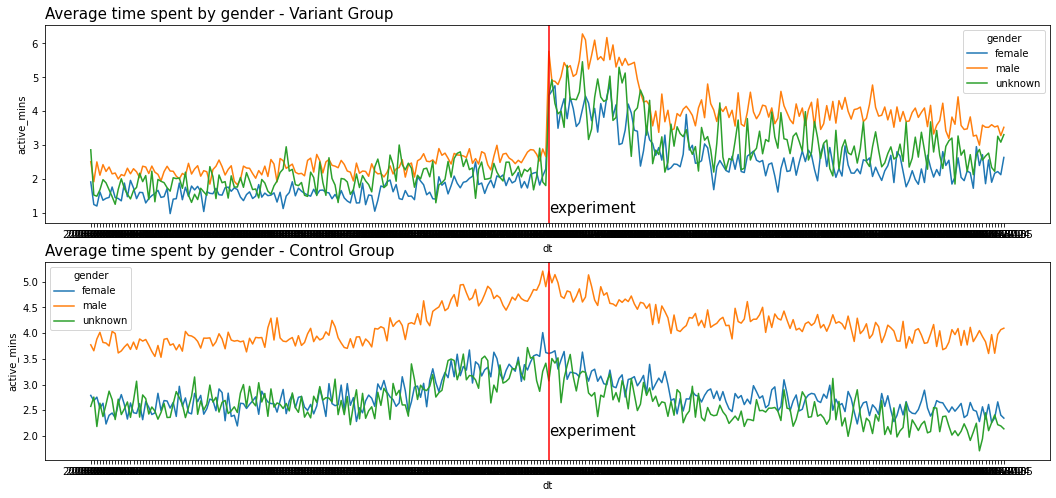

In [ ]:
plt.figure(figsize=(18,8))
plt.subplot(2,1,1)
plt.title('Average time spent by gender - Variant Group',loc='left', fontsize=15)
data=daily_usr_1.groupby(['gender','dt'],as_index=False).active_mins.mean()
sns.lineplot(data=data,x='dt',y='active_mins',hue='gender')
plt.axvline(x = daily_usr_1.experiement_dt.max(), color = 'red')
plt.text(x = daily_usr_1.experiement_dt.max(),y=1,s ='experiment', fontsize =15)
plt.subplot(2,1,2)
plt.title('Average time spent by gender - Control Group',loc='left',fontsize=15)
data=daily_usr_0.groupby(['gender','dt'],as_index=False).active_mins.mean()
sns.lineplot(data=data,x='dt',y='active_mins',hue='gender')
plt.axvline(x = daily_usr_0.experiement_dt.max(), color = 'red')
plt.text(x = daily_usr_0.experiement_dt.max(),y=2,s ='experiment', fontsize =15)
plt.savefig("Time Series Analysis for Average time spent by gender")

Thus we see from above graph that for variant group=1 or Treatment group there is significant improvement in average acitve minutes. Also, comparing within the genders, we see male members have a higher activity in comparison their female counterparts. In control group there is not much change in acitivity.

# Checking if the distribution of users across user_types is balanced or not!¶

In [ ]:
temp = pd.merge(t2_usr_variant,t4_usr_attributes,on="uid",how="left")
print(t2_usr_variant.shape[0], t4_usr_attributes.shape[0], temp.shape[0])
temp.groupby(['variant_number','user_type'],as_index=False).agg({'uid':'count'})

50000 50000 50000


,variant_number,user_type,uid
0,0,contributor,915
1,0,new_user,3653
2,0,non_reader,28699
3,0,reader,6733
4,1,contributor,129
5,1,new_user,1235
6,1,non_reader,7367
7,1,reader,1269


### Thus we see that though the distribution of reader, non-reader & contributor users are same in both variant group there is a high proportion of non-reader users in the control & treatment groups. Given that the aim was to increase user engagement amongst all types of users, therefore the distribution should have been balanced. But having said so, I am also wondering if there was some critical changes introduced in new UI meant for converting non-reader users to other types. This information will be probably more useful. 

In [ ]:
print("Before the Experiment:")
daily_usr_act_pre.groupby(['variant_number','user_type'],as_index=False).active_mins.agg({'mean','std','median','count'})

print("After the Experiment:")
daily_usr_act_prepost.groupby(['variant_number','user_type'],as_index=False).active_mins.agg({'mean','std','median','count'})

Before the Experiment:


mean  median       std    count
variant_number user_type                                       
0              contributor 31.377330       0 78.160294   118350
               non_reader   0.679109       0  4.643202  3279300
               reader      10.672939       0 32.850768   869850
1              contributor 20.423425       0 59.951643    16350
               non_reader   0.632386       0  3.987967   838950
               reader       7.817684       0 25.093694   166650

After the Experiment:


mean  median       std    count
variant_number user_type                                       
0              contributor 30.591390       0 75.813302   118350
               non_reader   0.746917       0  5.362558  3279300
               reader      10.670074       0 32.702177   869850
1              contributor 31.027951       0 87.315865    16350
               non_reader   1.164220       0  8.378647   838950
               reader      13.569739       0 43.927194   166650

<Figure size 1296x576 with 0 Axes>

Text(0.0, 1.0, 'Average time spent by user_type - Variant Group')

Text(2019-02-06, 1, 'experiment')

Text(0.0, 1.0, 'Average time spent by user_type - Control Group')

Text(2019-02-06, 2, 'experiment')

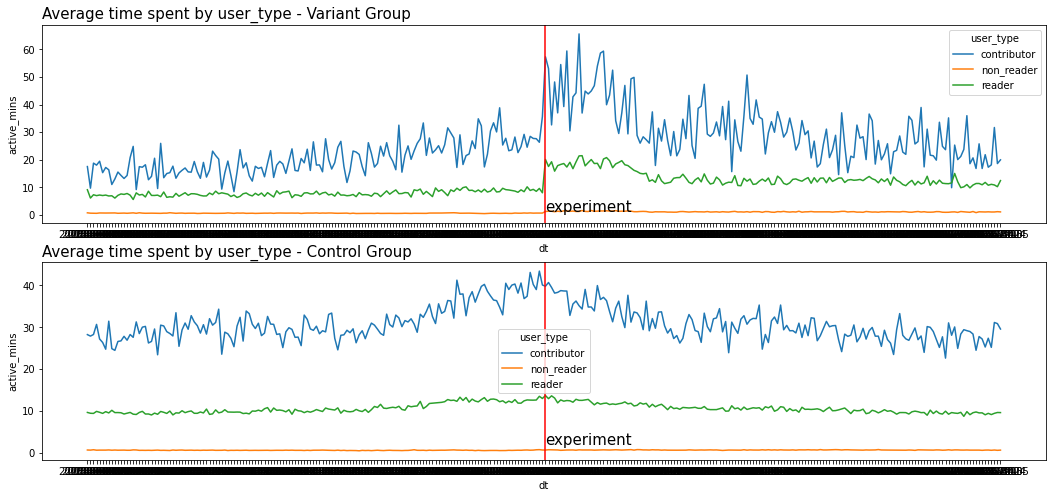

In [ ]:
plt.figure(figsize=(18,8))
plt.subplot(2,1,1)
plt.title('Average time spent by user_type - Variant Group',loc='left', fontsize=15)
data=daily_usr_1.groupby(['user_type','dt'],as_index=False).active_mins.mean()
sns.lineplot(data=data,x='dt',y='active_mins',hue='user_type')
#plt.xticks(np.arange(daily_usr_1.dt.min(),daily_usr_1.dt.max(),30))
plt.axvline(x = daily_usr_1.experiement_dt.max(), color = 'red')
plt.text(x = daily_usr_1.experiement_dt.max(),y=1,s ='experiment', fontsize =15)
plt.subplot(2,1,2)
plt.title('Average time spent by user_type - Control Group',loc='left',fontsize=15)
data=daily_usr_0.groupby(['user_type','dt'],as_index=False).active_mins.mean()
sns.lineplot(data=data,x='dt',y='active_mins',hue='user_type')
plt.axvline(x = daily_usr_0.experiement_dt.max(), color = 'red')
plt.text(x = daily_usr_0.experiement_dt.max(),y=2,s ='experiment', fontsize =15)
plt.savefig("Time Series Analysis for Average time spent by user_type")

## Performing Co-variates test

### Gender

In [ ]:
gender = ['male','female','unknown']
for user in gender:
    print(user)
    mean_0_pp = daily_usr_0[daily_usr_0['gender']==user].active_mins.mean()
    mean_1_pp = daily_usr_1[daily_usr_1['gender']==user].active_mins.mean()

    std_0_pp = daily_usr_0[daily_usr_0['gender']==user].active_mins.std()
    std_1_pp = daily_usr_1[daily_usr_1['gender']==user].active_mins.std()

    nobs0_pp = daily_usr_0[daily_usr_0['gender']==user].active_mins.count()
    nobs1_pp = daily_usr_1[daily_usr_1['gender']==user].active_mins.count()
    
    print('T-results for user type-',user)
    print(ttest_ind_from_stats(mean1=mean_1_pp,std1=std_1_pp,nobs1=nobs1_pp,
                     mean2=mean_0_pp,std2=std_0_pp,nobs2=nobs0_pp, equal_var=False))


male
T-results for user type- male
Ttest_indResult(statistic=-40.89238052193022, pvalue=0.0)
female
T-results for user type- female
Ttest_indResult(statistic=-26.555714805327135, pvalue=2.506335129311254e-155)
unknown
T-results for user type- unknown
Ttest_indResult(statistic=-1.2571698339802369, pvalue=0.2086927807651504)


### User_Type


In [ ]:
user_type = ['non_reader','contributor','reader']
for user in user_type:
    print(user)

    mean_0_pp = daily_usr_0[daily_usr_0['user_type']==user].active_mins.mean()
    mean_1_pp = daily_usr_1[daily_usr_1['user_type']==user].active_mins.mean()

    std_0_pp = daily_usr_0[daily_usr_0['user_type']==user].active_mins.std()
    std_1_pp = daily_usr_1[daily_usr_1['user_type']==user].active_mins.std()

    nobs0_pp = daily_usr_0[daily_usr_0['user_type']==user].active_mins.count()
    nobs1_pp = daily_usr_1[daily_usr_1['user_type']==user].active_mins.count()
    
    print('T-results for user type-',user)
    print(ttest_ind_from_stats(mean1=mean_1_pp,std1=std_1_pp,nobs1=nobs1_pp,
                     mean2=mean_0_pp,std2=std_0_pp,nobs2=nobs0_pp, equal_var=False))



contributor
T-results for user type- contributor
Ttest_indResult(statistic=-11.834916226870043, pvalue=2.8930249870937706e-32)
reader
T-results for user type- reader
Ttest_indResult(statistic=0.3316864679767433, pvalue=0.7401261755642135)
non_reader
T-results for user type- non_reader
Ttest_indResult(statistic=34.09324557971776, pvalue=1.0829136072296474e-254)
